**Prática 4 – Aplicação e Combinação de Classificadores Avançados**

**Alunos:

GIOVANNI SURIANI FERREIRA

JORGE ALIOMAR TROCOLI ABDON DANTAS**

**Objetivo(s):**

Nesta atividade prática, você irá aplicar três dos classificadores mais avançados em Aprendizado de Máquina para dados
tabulares: XGBoost, LightGBM e CatBoost. Em seguida, irá combiná-los utilizando duas estratégias de ensemble:
VotingClassifier e StackingClassifier. O desempenho dos modelos será avaliado por meio de validação cruzada
estratificada com 10 folds e por submissão dos resultados ao leaderboard do Kaggle.

# DESAFIO E PROBLEMA ESCOLHIDO
Home Credit Default Risk (https://www.kaggle.com/competitions/home-credit-default-risk)

O desafio consiste em melhorar os modelos preditivos, da HOME CREDIT, de crédito voltados a pessoas sem histórico bancário. Utilizando dados alternativos como registros de telecomunicações e transações, a empresa quer garantir que mais pessoas aptas recebam empréstimos justos e sustentáveis. O desafio propõe que os participantes usem técnicas de ciência de dados e machine learning para prever com mais precisão a capacidade de pagamento dos clientes.

O conjunto de dados contém informações detalhadas sobre o histórico financeiro de clientes da Home Credit e de outras instituições, com o objetivo de prever a capacidade de pagamento de novos empréstimos.

 - application_{train|test}.csv: Esta é a tabela principal, dividida em dois arquivos: Treinamento (com a variável TARGET) e Teste (sem TARGET). Contém dados estáticos de todas as solicitações de empréstimo. Cada linha representa um empréstimo.

 - bureau.csv: Todos os créditos anteriores dos clientes fornecidos por outras instituições financeiras, reportados ao Bureau de Crédito (apenas para clientes com empréstimo na amostra). Cada linha representa um crédito anterior registrado antes da data da aplicação atual.
 
 - bureau_balance.csv: Saldos mensais dos créditos anteriores no Bureau de Crédito. Cada linha representa um mês de histórico para cada crédito anterior — ou seja, número de empréstimos * número de créditos anteriores * número de meses com histórico disponível.

 - POS_CASH_balance.csv: Saldos mensais dos empréstimos anteriores no ponto de venda (POS) ou empréstimos em dinheiro que o cliente teve com a Home Credit. Uma linha por mês de histórico de cada crédito anterior relacionado ao empréstimo na amostra.

 - credit_card_balance.csv: Saldos mensais dos cartões de crédito anteriores que o cliente tem com a Home Credit. Formato similar ao POS_CASH_balance, mas para cartões de crédito.

 - previous_application.csv: Todas as solicitações anteriores de empréstimos feitas à Home Credit por clientes com empréstimos na amostra atual. Uma linha por solicitação anterior.

 - installments_payments.csv: Histórico de pagamentos de créditos anteriores concedidos pela Home Credit. Inclui: a) uma linha para cada pagamento feito, e b) uma linha para cada parcela não paga. Cada linha representa um pagamento ou uma parcela de um crédito anterior.

 - HomeCredit_columns_description.csv: Arquivo com a descrição das colunas de todos os outros arquivos do conjunto de dados.

 As tabelas podem se relacionar conforme imagem abaixo:

 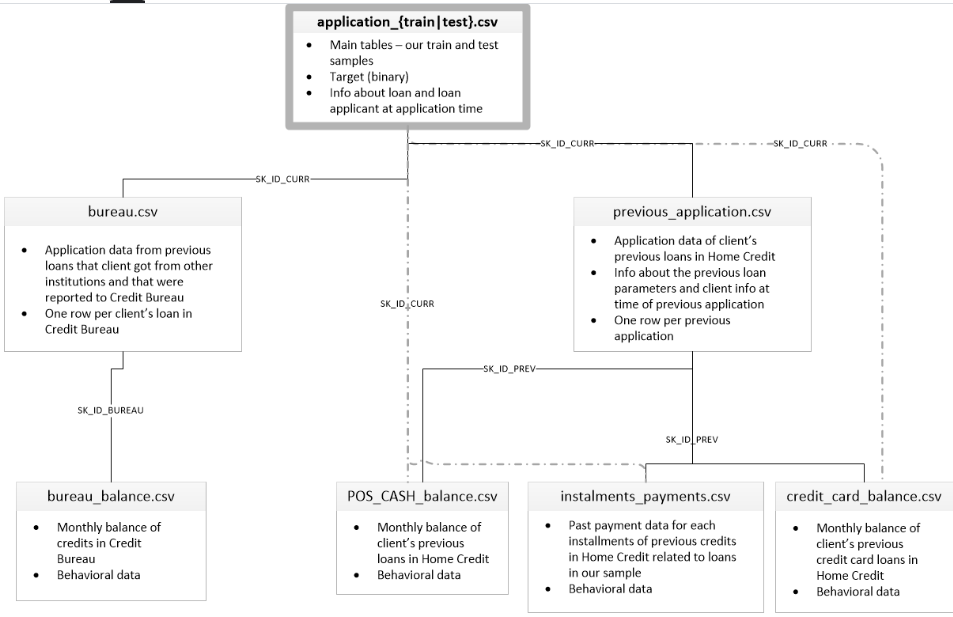




# PREPARAÇÃO DA BASE DE DADOS - Todos os dados

In [1]:
#Importando Bibliotecas Pandas
import pandas as pd

#Importando BiBliotecas DASK  (alternativa ao Pandas)
import dask.dataframe as dd

In [2]:
#Carregando Base de dados principal
df_test  = pd.read_csv("E:/Documentos/CEFET/OneDrive/Documentos/2ECOM067_INTELIGENCIA-COMPUTACIONAL-I_T01/TP1/bases/application_test.csv")
df_train = pd.read_csv("E:/Documentos/CEFET/OneDrive/Documentos/2ECOM067_INTELIGENCIA-COMPUTACIONAL-I_T01/TP1/bases/application_train.csv")

In [3]:
# Como o volume de informações é muito grande, iremos ao invés de montar uma base única entre a base principal e as 
# demais tabelas auxiliares, iremos criar 4 bases (conforme descrito abaixo), realizar as devidas simulações e utilizar 
# as estratégias de emsemble VotingClassifier e StackingClassifier.
# Bases que serão construídas:
#   -   df_01 = application_train + bureau + bureau_balance
#   -   df_02 = application_train + previous_application + POS_CASH_balance
#   -   df_03 = application_train + previous_application + installments_payments
#   -   df_04 = application_train + previous_application + credit_card_balance

## DataFrame 01 = application_train + bureau + bureau_balance

In [4]:
#Carregamento de Bases de Dados Auxiliares
df_auxiliar_bureau                          = pd.read_csv("E:/Documentos/CEFET/OneDrive/Documentos/2ECOM067_INTELIGENCIA-COMPUTACIONAL-I_T01/TP1/bases/bureau.csv")
df_auxiliar_bureau_balance                  = pd.read_csv("E:/Documentos/CEFET/OneDrive/Documentos/2ECOM067_INTELIGENCIA-COMPUTACIONAL-I_T01/TP1/bases/bureau_balance.csv")

In [5]:
#Copia do df_train
df_01 = df_train.copy()

In [6]:
#Realização do left join de df_train com df_auxiliar_bureau
# DF da esquerda = df_train
# DF da direita  = df_auxiliar_bureau
df_01 = df_01.join(df_auxiliar_bureau, on='SK_ID_CURR', lsuffix = ' ', how='left')
df_01 = df_01.drop(columns={"SK_ID_CURR"}) #Excluir coluna duplicada

#Realização do left join de df_01 com df_auxiliar_bureau_balance
# DF da esquerda = df_01
# DF da direita  = df_auxiliar_bureau_balance
df_01 = df_01.join(df_auxiliar_bureau_balance, on='SK_ID_BUREAU', lsuffix = ' ',  how='left')
df_01 = df_01.drop(columns={"SK_ID_BUREAU"}) #Excluir coluna duplicada

## DataFrame 02 = application_train + previous_application + POS_CASH_balance

In [7]:
#Carregamento de Bases de Dados Auxiliares
df_auxiliar_previous_application            = pd.read_csv("E:/Documentos/CEFET/OneDrive/Documentos/2ECOM067_INTELIGENCIA-COMPUTACIONAL-I_T01/TP1/bases/previous_application.csv")
df_auxiliar_POS_CASH_balance                = pd.read_csv("E:/Documentos/CEFET/OneDrive/Documentos/2ECOM067_INTELIGENCIA-COMPUTACIONAL-I_T01/TP1/bases/POS_CASH_balance.csv")

In [8]:
#Copia do df_train
df_02 = df_train.copy()

In [9]:
#Realização do left join de df_train com df_auxiliar_previous_application
# DF da esquerda = df_train
# DF da direita  = df_auxiliar_previous_application
df_02 = df_02.join(df_auxiliar_previous_application, on='SK_ID_CURR', lsuffix = ' ', how='left')
df_02 = df_02.drop(columns={"SK_ID_CURR"}) #Excluir coluna duplicada

#Realização do left join de df_02 com df_auxiliar_POS_CASH_balance
# DF da esquerda = df_02
# DF da direita  = df_auxiliar_POS_CASH_balance
df_02 = df_02.join(df_auxiliar_POS_CASH_balance, on='SK_ID_PREV', lsuffix = ' ',  how='left')
df_02 = df_02.drop(columns={"SK_ID_PREV"}) #Excluir coluna duplicada

## DataFrame 03 = application_train + previous_application + installments_payments

In [10]:
#Carregamento de Bases de Dados Auxiliares
#df_auxiliar_previous_application            = pd.read_csv("E:/Documentos/CEFET/OneDrive/Documentos/2ECOM067_INTELIGENCIA-COMPUTACIONAL-I_T01/TP1/bases/previous_application.csv")
df_auxiliar_installments_payments           = pd.read_csv("E:/Documentos/CEFET/OneDrive/Documentos/2ECOM067_INTELIGENCIA-COMPUTACIONAL-I_T01/TP1/bases/installments_payments.csv")

In [11]:
#Copia do df_train
df_03 = df_train.copy()

In [12]:
#Realização do left join de df_train com df_auxiliar_previous_application
# DF da esquerda = df_train
# DF da direita  = df_auxiliar_previous_application
df_03 = df_03.join(df_auxiliar_previous_application, on='SK_ID_CURR', lsuffix = ' ', how='left')
df_03 = df_03.drop(columns={"SK_ID_CURR"}) #Excluir coluna duplicada

#Realização do left join de df_03 com df_auxiliar_installments_payments
# DF da esquerda = df_03
# DF da direita  = df_auxiliar_installments_payments
df_03 = df_03.join(df_auxiliar_installments_payments, on='SK_ID_PREV', lsuffix = ' ',  how='left')
df_03 = df_03.drop(columns={"SK_ID_PREV"}) #Excluir coluna duplicada

## DataFrame 04 = application_train + previous_application + credit_card_balance

In [13]:
#Carregamento de Bases de Dados Auxiliares
#df_auxiliar_previous_application            = pd.read_csv("E:/Documentos/CEFET/OneDrive/Documentos/2ECOM067_INTELIGENCIA-COMPUTACIONAL-I_T01/TP1/bases/previous_application.csv")
df_auxiliar_credit_card_balances            = pd.read_csv("E:/Documentos/CEFET/OneDrive/Documentos/2ECOM067_INTELIGENCIA-COMPUTACIONAL-I_T01/TP1/bases/credit_card_balance.csv")

In [14]:
#Copia do df_train
df_04 = df_train.copy()

In [15]:
#Realização do left join de df_train com df_auxiliar_previous_application
# DF da esquerda = df_train
# DF da direita  = df_auxiliar_previous_application
df_04 = df_04.join(df_auxiliar_previous_application, on='SK_ID_CURR', lsuffix = ' ', how='left')
df_04 = df_04.drop(columns={"SK_ID_CURR"}) #Excluir coluna duplicada

#Realização do left join de df_03 com df_auxiliar_credit_card_balances
# DF da esquerda = df_04
# DF da direita  = df_auxiliar_credit_card_balances
df_04 = df_04.join(df_auxiliar_credit_card_balances, on='SK_ID_PREV', lsuffix = ' ',  how='left')
df_04 = df_04.drop(columns={"SK_ID_PREV"}) #Excluir coluna duplicada

In [16]:
# Tamanhos dos Data Frames criados
print(df_01.shape, df_02.shape, df_03.shape, df_04.shape)

(307511, 140) (307511, 165) (307511, 165) (307511, 180)


# PREPARAÇÃO DA BASE DE DADOS - Amostra

Como as bases de dados original tem muitos valores, e as simulações subsequentes podem demorar muitas horas, realizar-se-a uma amostra aleatória das bases para treinamento e teste 


In [ ]:
#Amostra df_01
df_01_amostrado = df_01.sample(frac=0.2, random_state=42)  # Seleciona 20% do DataFrame


#Divisão treino e teste
X_train_df_01_amostrado =  df_01_amostrado.drop(columns={"TARGET"})
y_train_df_01_amostrado =  df_01_amostrado.TARGET

In [18]:
#Amostra df_02
df_02_amostrado = df_02.sample(frac=0.2, random_state=42)  # Seleciona 20% do DataFrame

#Divisão treino e teste
X_train_df_02_amostrado =  df_02_amostrado.drop(columns={"TARGET"})
y_train_df_02_amostrado =  df_02_amostrado.TARGET

In [19]:
#Amostra df_03
df_03_amostrado = df_03.sample(frac=0.2, random_state=42)  # Seleciona 20% do DataFrame

#Divisão treino e teste
X_train_df_03_amostrado =  df_03_amostrado.drop(columns={"TARGET"})
y_train_df_03_amostrado =  df_03_amostrado.TARGET

In [20]:
#Amostra df_04
df_04_amostrado = df_04.sample(frac=0.2, random_state=42)

#Divisão treino e teste
X_train_df_04_amostrado =  df_04_amostrado.drop(columns={"TARGET"})
y_train_df_04_amostrado =  df_04_amostrado.TARGET

# 1. Treinamento Individual dos Classificadore

In [21]:
#Importanto as Bibliotecas dos classificadores
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

In [ ]:
#Lista dos Modelos por Classificador
modelos =   [('XGBOOST  - Config.01 - random_state=42, learning_rate = 0.3, max_depth = 6', XGBClassifier(random_state=42, learning_rate = 0.3, max_depth = 6)), 
             ('XGBOOST  - Config.02 - random_state=42, learning_rate = 0.3, max_depth = 8', XGBClassifier(random_state=42, learning_rate = 0.3, max_depth = 8)), 
             ('XGBOOST  - Config.03 - random_state=42, learning_rate = 0.2, max_depth = 6', XGBClassifier(random_state=42, learning_rate = 0.2, max_depth = 6)), 
             ('XGBOOST  - Config.04 - random_state=42, learning_rate = 0.2, max_depth = 8', XGBClassifier(random_state=42, learning_rate = 0.2, max_depth = 8)), 
             ('LIGHTGBM - Config.01 - random_state=42, learning_rate = 0.3, max_depth = 6', LGBMClassifier(random_state=42, learning_rate = 0.3, max_depth = 6)), 
             ('LIGHTGBM - Config.02 - random_state=42, learning_rate = 0.3, max_depth = 8', LGBMClassifier(random_state=42, learning_rate = 0.3, max_depth = 8)), 
             ('LIGHTGBM - Config.03 - random_state=42, learning_rate = 0.2, max_depth = 6', LGBMClassifier(random_state=42, learning_rate = 0.2, max_depth = 6)), 
             ('LIGHTGBM - Config.04 - random_state=42, learning_rate = 0.2, max_depth = 8', LGBMClassifier(random_state=42, learning_rate = 0.2, max_depth = 8)), 
             ('CATBOOST - Config.01 - random_state=42, learning_rate = 0.3, max_depth = 6', CatBoostClassifier(random_state=42, learning_rate = 0.3, max_depth = 6)), 
             ('CATBOOST - Config.02 - random_state=42, learning_rate = 0.3, max_depth = 8', CatBoostClassifier(random_state=42, learning_rate = 0.3, max_depth = 8)), 
             ('CATBOOST - Config.03 - random_state=42, learning_rate = 0.2, max_depth = 6', CatBoostClassifier(random_state=42, learning_rate = 0.2, max_depth = 6)), 
             ('CATBOOST - Config.04 - random_state=42, learning_rate = 0.2, max_depth = 8', CatBoostClassifier(random_state=42, learning_rate = 0.2, max_depth = 8)),     
            ]

In [29]:
#Transformando as variáveis catégóricas em binárias via get.dummies

#Seleção dos atributos categóricos do dof_01
atributos_categoricos = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                         'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
                         'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
                         'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
                         'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
                         'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE', 'STATUS'
]

# Transformar usando pd.get_dummies
X_train_df_01_amostrado_dummificado = pd.get_dummies(X_train_df_01_amostrado, columns=atributos_categoricos, drop_first=True)

In [33]:
#Treino df_01
from sklearn.model_selection import cross_validate

Resultados=[]
for nome, classifier in modelos:
  scores = cross_validate(classifier, X_train_df_01_amostrado_dummificado, y_train_df_01_amostrado, scoring=['roc_auc'], cv = 10)
  scores_roc_auc  = scores["test_roc_auc"].mean()
  Resultados.append({'Modelo': nome,
                    'roc_auc': scores_roc_auc})

In [ ]:
#Impressão dos Resultados
print(f'Modelo \t\t\t\t\t\t\t\t\t\t\t ROC_UAC')
for r in Resultados:
    print(f'{r["Modelo"]:<90}{r["roc_auc"]:.4f}')

Modelo 											 ROC_UAC
XGBOOST  - Config.01 - random_state=42, learning_rate = 0.3, max_depth = 6                0.7154


In [ ]:
#Removendo o atributo `ID_code`, porque essa coluna não trará informação para a classificação
X_test = df_test.drop(columns=["ID_code"])
X_test

# SELECIONANDO MELHOR CLASSIFICADOR USANDO CROSS_VALIDATE - Não Ajustado

In [ ]:
Resultado

#TREINAMENTO E PREDIÇÃO - Árvore de Decisão

##NÃO AJUSTADO - F1 Macro

In [ ]:
#Importando o Classificador
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Normalização
# Para o classificador Árvore de Decisão a Normalização não faz diferença

# Importanto Biblioteca do Normalizador Padrão
#from sklearn.preprocessing   import StandardScaler;

In [ ]:
#Importando biblioteca train_test_split
from sklearn.model_selection import train_test_split; # train_test_split do sklearn

# Divisão treino/teste
X_train_local, X_test_local, y_train_local, y_test_local = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

In [ ]:
#Instanciamento do classificador
classifier = DecisionTreeClassifier(random_state=42,max_depth=10)

In [ ]:
#Treinamento do Classificador
classifier.fit(X_train_local, y_train_local)


In [ ]:
#Predição do Modelo Local
y_pred_local = classifier.predict(X_test_local)

In [ ]:
#Determinação do F1 Score Macro

#Importando Biblioteca de Métricas - F1 Score Macro
from sklearn.metrics import f1_score

#Calculo do accuracy_score
f1_sc = f1_score(y_test_local,y_pred_local, average = 'macro')
f1_sc

In [ ]:
#Predição do Modelo com os dados de Teste Global
predictions = classifier.predict(X_test)

In [ ]:
#Geração do Data Frame das predições com o Teste Global
df_test["target"] = predictions

In [ ]:
#Exibição do Data Frame que será enviado para o Kaggle
df_test[["ID_code","target"]]

In [ ]:
#Salvar o Data Frame que será enviado ao Kaggle em um arquivo .CSV
df_test[["ID_code","target"]].to_csv("solucao-2025_ArvoreDecisao_NãoAjustado_F1Score.csv", index=False)

#RESULTADOS